In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import joblib
from torch.utils.data import TensorDataset, DataLoader
import os
import matplotlib.pyplot as plt


In [7]:
# 建立PyTorch LSTM模型
class LSTM_Model(nn.Module):
    def __init__(self, n_column):
        super(LSTM_Model, self).__init__()
        self.lstm1 = nn.LSTM(input_size=n_column, hidden_size=50, batch_first=True)#两层LSTM层，每层有50个隐藏单元
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        self.fc = nn.Linear(50, 1)#全连接层
        
    def forward(self, x):#定义了前向传播过程
        x, (hn, cn) = self.lstm1(x)
        x, (hn, cn) = self.lstm2(x)
        x = self.fc(x[:, -1, :])
        return x #输出将是预测值
    
def data_preparation(features, labels, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(labels[i+seq_length])
    return np.array(X), np.array(y)

In [21]:
df=pd.read_excel("/Users/hanqiyu/Desktop/lstm/对一个油站一个油品做预测/临阵磨枪_MDCL_300874.xlsx")


# 选择特征和标签
features = df[['当天温度','当天油价',
                         '节假日_embed_0','当时天气_embed_0',
                         '节假日_embed_1','当时天气_embed_1','节假日_embed_2','当时天气_embed_2']].values
labels = df['历史销量'].values

# 标准化特征 (这里简单地使用了每列的最大值来归一化，实际应用中可能需要更精细的方法)
features = features / features.max(axis=0)



# 将数据转换为模型需要的格式
# 假设我们使用过去5天的数据来预测下一天的销量
seq_length = 30
# 这里的data_preparation是一个假设的函数，你需要根据你的数据编写相应的代码
X, y = data_preparation(features, labels, seq_length)

# 划分数据集（这里简单地取前面的数据为训练集，后面的为测试集）
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
print(train_size)

47


/var/folders/hh/z5w_l0t51430lc8vrbl98jfh0000gn/T/ipykernel_61874/2445663220.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/hh/z5w_l0t51430lc8vrbl98jfh0000gn/T/ipykernel_61874/2445663220.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
/var/folders/hh/z5w_l0t51430lc8vrbl98jfh0000gn/T/ipykernel_61874/2445663220.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.

Epoch 0, Loss: 133048504.0
Epoch 1, Loss: 133047216.0
Epoch 2, Loss: 133045944.0
Epoch 3, Loss: 133044648.0
Epoch 4, Loss: 133043328.0
Epoch 5, Loss: 133041976.0
Epoch 6, Loss: 133040552.0
Epoch 7, Loss: 133039040.0
Epoch 8, Loss: 133037448.0
Epoch 9, Loss: 133035672.0
Epoch 10, Loss: 133033752.0
Epoch 11, Loss: 133031632.0
Epoch 12, Loss: 133029248.0
Epoch 13, Loss: 133026600.0
Epoch 14, Loss: 133023664.0
Epoch 15, Loss: 133020432.0
Epoch 16, Loss: 133016936.0
Epoch 17, Loss: 133013192.0
Epoch 18, Loss: 133009256.0
Epoch 19, Loss: 133005272.0
Epoch 20, Loss: 133001272.0
Epoch 21, Loss: 132997336.0
Epoch 22, Loss: 132993528.0
Epoch 23, Loss: 132989840.0
Epoch 24, Loss: 132986272.0
Epoch 25, Loss: 132982776.0
Epoch 26, Loss: 132979376.0
Epoch 27, Loss: 132976048.0
Epoch 28, Loss: 132972784.0
Epoch 29, Loss: 132969584.0
Epoch 30, Loss: 132966424.0
Epoch 31, Loss: 132963360.0
Epoch 32, Loss: 132960320.0
Epoch 33, Loss: 132957344.0
Epoch 34, Loss: 132954440.0
Epoch 35, Loss: 132951584.0
Ep

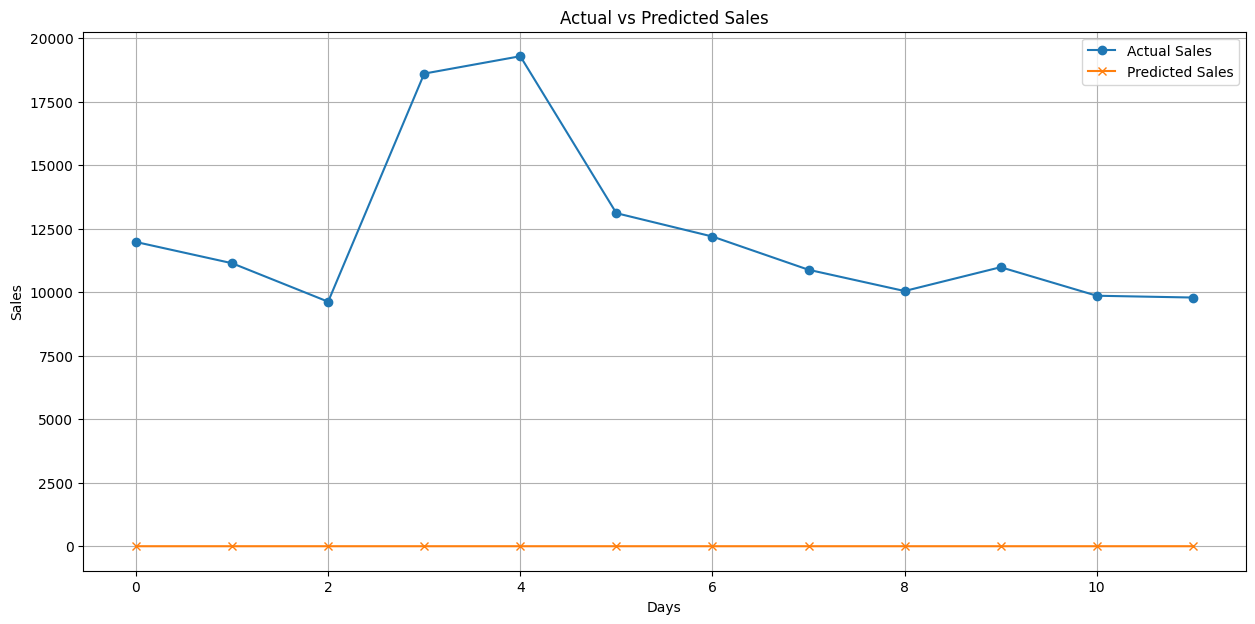

In [23]:

# 将数据转换为 PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 初始化模型
n_features = X_train.shape[2]  # 特征数
model = LSTM_Model(n_features)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 50  # 定义训练周期
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# 评估模型
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
print(f'Test Loss: {test_loss.item()}')


# 真实值 - 使用示例数据中的 '历史销量' 列
# 预测值 - 这将是你模型预测的结果
predicted_values = predictions  # 使用上面得到的预测结果

# 绘图
plt.figure(figsize=(15, 7))
plt.plot(y_test, label='Actual Sales', marker='o')
plt.plot(predicted_values, label='Predicted Sales', marker='x')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
print(len(predictions))
print(len(y_test))

26
26


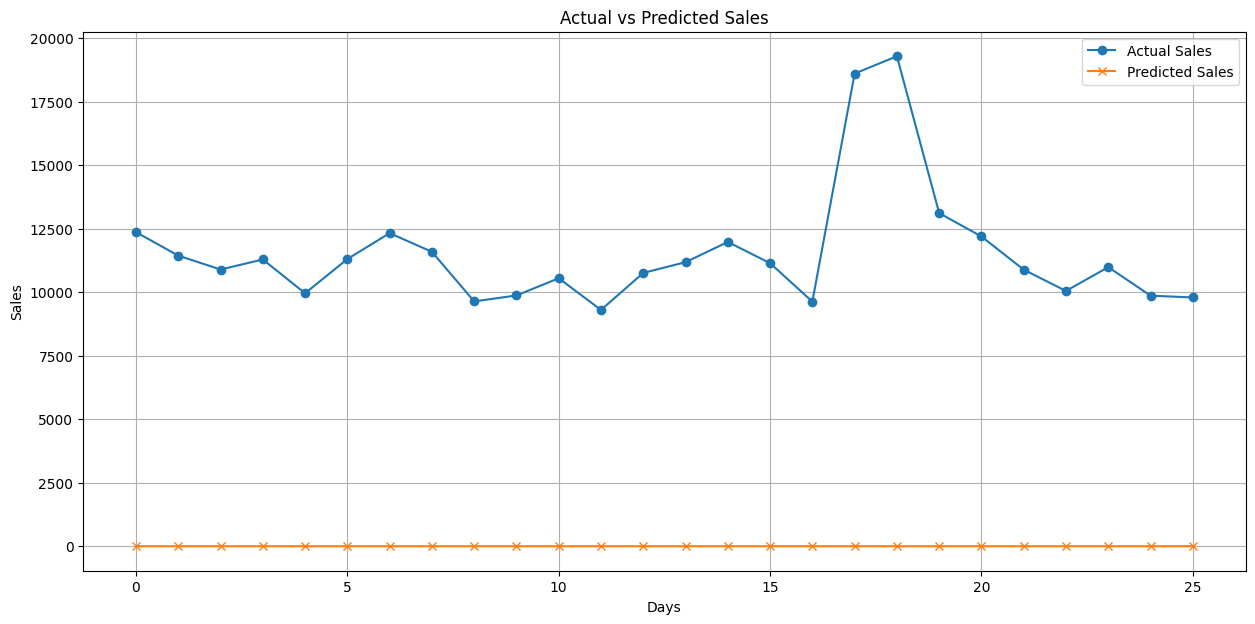